🚀 Using cuda
✅ Special tokens bound: 0 1 2 3 4
📚 Dataset: 24147 samples | Vocab size: 793


Epoch 1/1:   0%|          | 0/3019 [00:00<?, ?it/s]

Epoch 1: train 1.128 | eval 0.381 | ppl 1.46
✅ Model reloaded successfully.
🧪 Generation Test (Reloaded):
--- Sample 1 ---
</s> <s> [C] [=C] [C] [Ring1] [=Branch2] [C] [=C] [C] [=C] [=C] [Ring1] [=Branch1] [C] [C] [Branch1] [C] [C] [C] [Ring1]
--- Sample 2 ---
</s> [C] [N] [C] [C] [=N] [S] [Branch1] [Branch1] [C] [C] [C] [C] [C] [Branch1] [C] [C] [Branch1] [C] [C] [=Branch1] [C] [=O] [O] [C] [Ring1] [=Branch1] [C] [C] [C] [C] [O] [O] [Ring1] [C] [C] [C] [C] [Ring2] <s> <s> <s> <s> [Cl] [F] [C] [Ring1] [Branch1] [C] [C] [Branch1] [C] [C] [C] [C] [=C] [NH1] [C] [N] [C] [=C] [C] [=C] [N] [Ring1] <s> <s> [N] [C] [=C] [C] [=C] [C] [=C] [Ring1] <s> <s> <s> <s> <s> [C] [N] [C] [=C] [Ring2] [NH1] [Ring1] [=Branch2] [C] [C] [C] [=C] [Ring1] [N] [C] [C] [=C] [C] [=C] [C] [Ring1] [C] [C] [O] [Cl] [O] [O] [Branch1]


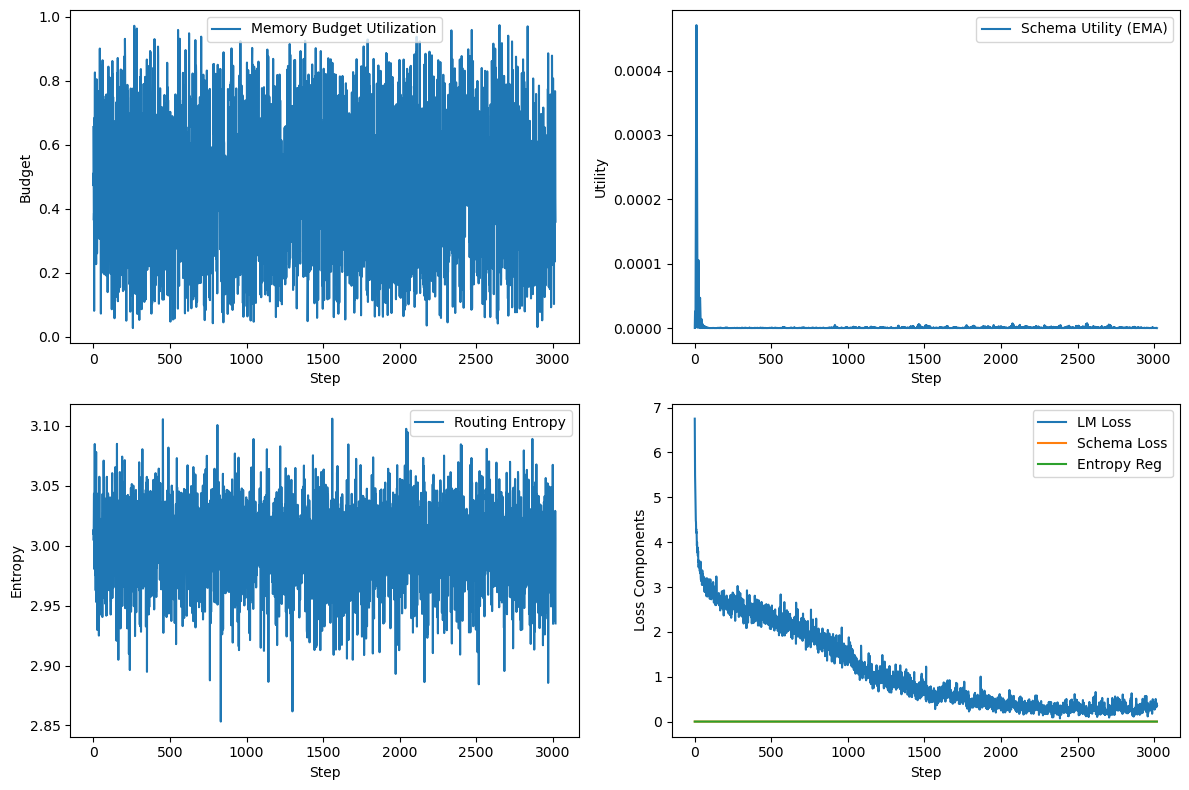

In [2]:
#!/usr/bin/env python
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd, random, numpy as np, time, math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from FastChemTokenizerHF import FastChemTokenizerSelfies
from scmt import SchemaAugmentedSOMT, SOMTConfig

# ====================================================
# 0. Setup
# ====================================================
seed = 2025
torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using {device}")

# ====================================================
# 1. Dataset + Tokenization
# ====================================================
class TextDataset(Dataset):
    def __init__(self, csv_path, tokenizer, seq_len=64):
        df = pd.read_csv(csv_path)
        self.texts = df["SELFIES"].astype(str).tolist() if "SELFIES" in df.columns else df.iloc[:, 0].astype(str).tolist()
        self.tokenizer = tokenizer
        self.seq_len = seq_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        toks = self.tokenizer.encode(self.texts[idx])
        toks = toks[: self.seq_len]
        if len(toks) < self.seq_len:
            toks += [self.tokenizer.pad_token_id] * (self.seq_len - len(toks))
        x = torch.tensor(toks, dtype=torch.long)
        y = torch.roll(x, shifts=-1, dims=0)
        return x, y

tokenizer = FastChemTokenizerSelfies.from_pretrained("./tokenizer_vocab/selftok_reordered")
seq_len = 90
train_ds = TextDataset("./data/test.csv", tokenizer, seq_len)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader  = DataLoader(train_ds, batch_size=16, shuffle=False)
vocab_size = tokenizer.vocab_size
print(f"📚 Dataset: {len(train_ds)} samples | Vocab size: {vocab_size}")

# ====================================================
# 2. Model Initialization (modular)
# ====================================================
config = SOMTConfig(vocab_size=vocab_size, d_model=256, nhead=8, num_layers=4, max_len=256, mem_size=128)
model = SchemaAugmentedSOMT(config.vocab_size, d_model=config.d_model, nhead=config.nhead, num_layers=config.num_layers,
                            max_len=config.max_len, mem_size=config.mem_size).to(device)

# ====================================================
# 3. Train & Evaluate with Tracking
# ====================================================
def evaluate(model, loader, criterion):
    model.eval(); total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits, *_ = model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    return avg_loss, np.exp(avg_loss)

def train_model(epochs=1):
    opt = torch.optim.AdamW(model.parameters(), lr=2e-4, betas=(0.9,0.95), weight_decay=0.01)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    history = {"train_loss": [], "eval_loss": [], "ppl": []}
    metrics_log = {"budget": [], "schema_util": [], "routing_entropy": [], "importance_l2": [], "importance_entropy": [], "lm_loss": [], "schema_loss": [], "entropy_reg": []}

    for ep in range(epochs):
        model.train(); total_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs}", leave=False)
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            logits, _, _, _, aux = model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            total_aux = sum(aux.values())
            (loss + total_aux).backward()
            opt.step()

            # tracking metrics
            with torch.no_grad():
                metrics_log["lm_loss"].append(loss.item())
                metrics_log["schema_loss"].append(aux["schema_utility"].item())
                metrics_log["entropy_reg"].append(aux["importance_entropy"].item())
                metrics_log["importance_l2"].append(aux["importance_l2"].item())

                if hasattr(model, "budget_controller"):
                    dummy = torch.randn(1, model.d_model, device=device)
                    budget = model.budget_controller(dummy).mean().item()
                    metrics_log["budget"].append(budget)

                if hasattr(model, "schema_router"):
                    dummy_keys = torch.randn(4, 8, model.d_model, device=device)
                    routing_probs = F.softmax(model.schema_router(dummy_keys), dim=-1)
                    entropy = -torch.sum(routing_probs * torch.log(routing_probs + 1e-12), dim=-1).mean().item()
                    metrics_log["routing_entropy"].append(entropy)

                metrics_log["schema_util"].append(aux["schema_utility"].item())

            total_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        tr_loss = total_loss / len(train_loader)
        ev_loss, ppl = evaluate(model, test_loader, criterion)
        history["train_loss"].append(tr_loss)
        history["eval_loss"].append(ev_loss)
        history["ppl"].append(ppl)
        print(f"Epoch {ep+1}: train {tr_loss:.3f} | eval {ev_loss:.3f} | ppl {ppl:.2f}")

    return model, history, metrics_log

# ====================================================
# 4. Generation (using integrated API)
# ====================================================
@torch.no_grad()
def generate_text(model, tokenizer, prompt="", max_len=80, temperature=0.8):
    model.eval()
    if prompt == "":
        input_ids = torch.tensor([[tokenizer.bos_token_id or tokenizer.eos_token_id]], dtype=torch.long).to(device)
    else:
        input_ids = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long).to(device)
    generated = model.generate(input_ids, max_length=max_len, temperature=temperature,
                               eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id)
    return tokenizer.decode(generated)

# ====================================================
# 5. Run Training + Generation + Save/Load + Plot
# ====================================================
model, hist, metrics = train_model(epochs=1)

# Save/Load dry test
save_dir = "./checkpoints/somt_w_test"
model.save_pretrained(save_dir)
model_loaded = SchemaAugmentedSOMT.from_pretrained(save_dir).to(device)
print("✅ Model reloaded successfully.")

# Quick sanity generation
print("🧪 Generation Test (Reloaded):")
for i in range(2):
    print(f"--- Sample {i+1} ---")
    print(generate_text(model_loaded, tokenizer, prompt="", max_len=60))

# ====================================================
# 6. Plot tracked metrics (Jupyter-friendly)
# ====================================================
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(metrics["budget"], label="Memory Budget Utilization")
plt.xlabel("Step"); plt.ylabel("Budget"); plt.legend()

plt.subplot(2,2,2)
plt.plot(metrics["schema_util"], label="Schema Utility (EMA)")
plt.xlabel("Step"); plt.ylabel("Utility"); plt.legend()

plt.subplot(2,2,3)
plt.plot(metrics["routing_entropy"], label="Routing Entropy")
plt.xlabel("Step"); plt.ylabel("Entropy"); plt.legend()

plt.subplot(2,2,4)
plt.plot(metrics["lm_loss"], label="LM Loss")
plt.plot(metrics["schema_loss"], label="Schema Loss")
plt.plot(metrics["entropy_reg"], label="Entropy Reg")
plt.xlabel("Step"); plt.ylabel("Loss Components"); plt.legend()

plt.tight_layout()
plt.show()

In [4]:
import selfies as sf

tokens = "[C] [N] [C] [C] [=N] [S] [Branch1] [Branch1] [C] [C] [C] [C] [C] [Branch1] [C] [C] [Branch1] [C] [C] [=Branch1] [C] [=O] [O] [C] [Ring1] [=Branch1] [C] [C] [C] [C] [O] [O] [Ring1] [C] [C] [C] [C] [Ring2] <s> <s> <s> <s> [Cl] [F] [C] [Ring1] [Branch1] [C] [C] [Branch1] [C] [C] [C] [C] [=C] [NH1] [C] [N] [C] [=C] [C] [=C] [N] [Ring1] <s> <s> [N] [C] [=C] [C] [=C] [C] [=C] [Ring1] <s> <s> <s> <s> <s> [C] [N] [C] [=C] [Ring2] [NH1] [Ring1] [=Branch2] [C] [C] [C] [=C] [Ring1] [N] [C] [C] [=C] [C] [=C] [C] [Ring1] [C] [C] [O] [Cl] [O] [O] [Branch1]"
tokens = tokens.replace(" ", "")
print(sf.decoder(tokens))

CNCC=NS(CCCC)C(C)(C)C=O


In [5]:
@torch.no_grad()
def visualize_schemas_correct(model, tokenizer, top_k=8):
    model.eval()
    device = next(model.parameters()).device

    # Get raw token embeddings
    embed_matrix = model.embed.weight.data  # (V, D)

    # Project them into KEY space (same as schema_keys)
    projected_tokens = model.key_proj(embed_matrix)  # (V, D)

    # Normalize both
    schema_norm = F.normalize(model.schema_keys, p=2, dim=-1)  # (S, D)
    token_norm = F.normalize(projected_tokens, p=2, dim=-1)     # (V, D)

    # Compute similarity in KEY space
    sim = torch.mm(schema_norm, token_norm.T)  # (S, V)

    # Decode top tokens
    for i in range(sim.size(0)):
        top_vals, top_ids = torch.topk(sim[i], k=top_k, largest=True)
        tokens = [tokenizer.decode([tid.item()]) for tid in top_ids]
        print(f"Schema {i:2d}: " + " | ".join(f"{t} ({v:.3f})" for t, v in zip(tokens, top_vals)))

In [6]:
visualize_schemas_correct(model, tokenizer, top_k=8)

Schema  0: [C] (0.576) | [N] [C] [C] [C] [C] (0.539) | [O] [C] [Branch1] (0.511) | [C] [C] [C] [Branch1] (0.497) | [N] [C] [C] (0.488) | [N] (0.480) | [N] [C] (0.471) | [N] [C] [C] [C] (0.465)
Schema  1: [C] (0.534) | [N] [C] [C] [C] [C] (0.517) | [#C] (0.464) | [N] [C] (0.435) | [=N] (0.433) | [Ring2] (0.431) | [C] [C] [C] [Branch1] (0.423) | [O] [C] [C] [C] [C] (0.419)
Schema  2: [N] [C] [C] [C] [C] (0.487) | [C] (0.477) | [O] [C] [C] [C] [C] (0.425) | [C] [C] [C] [Branch1] (0.410) | [N] [C] [=Branch1] [C] [=O] (0.397) | [N] [C] (0.391) | [N] [C] [C] (0.390) | [=Branch1] (0.372)
Schema  3: [C] (0.573) | [N] [C] [C] [C] [C] (0.535) | [Ring2] (0.515) | [#C] (0.485) | [C] [O] [C] (0.480) | [N] (0.477) | [=N] (0.475) | [N] [C] (0.465)
Schema  4: [N] (0.549) | [C] (0.514) | <s> (0.511) | [O] [C] [Branch1] (0.495) | [Branch1] (0.495) | [C] [=C] [C] [=C] (0.491) | [O] [C] [C] [=C] (0.490) | [N] [C] [C] [C] (0.461)
Schema  5: [N] [C] [C] [C] [C] (0.482) | [C] (0.421) | [O] [C] [C] [C] [C] (0